In [15]:
# default_exp features

# Features

In this notebook we inspect non fluorescence intensity features.

> API details.

In [16]:
#hide
from nbdev.showdoc import *

In [18]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload

numpy.random.seed(42)

In [19]:
# export

from ehv import load
import ppscore
import fcswrite
reload(load)

<module 'ehv.load' from 'd:\\dev\\active\\ehv-analysis\\ehv\\load.py'>

In [20]:
df_201 = load.remove_unwanted_features(load.load_raw_ideas("D:/Experiment_data/weizmann/EhV/201", load_labels=True))
df_control = load.remove_unwanted_features(load.load_raw_ideas("D:/Experiment_data/weizmann/EhV/control", load_labels=False))

In [21]:
df_201 = df_201.drop(columns=df_201.filter(regex=".*Intensity_MC(DAPI|TMR|Cy5|MCP).*"))
df_201_meta = df_201[["label", "replicate", "timepoint"]]
df_201 = df_201.drop(columns=["label", "replicate", "timepoint"])
df_201.shape

(150257, 134)

In [22]:
df_control = df_control.drop(columns=df_201.filter(regex=".*Intensity_MC(DAPI|TMR|Cy5|MCP).*"))
df_control_meta = df_control[["replicate", "timepoint"]]
df_control = df_control.drop(columns=["replicate", "timepoint"])
df_control.shape

(63376, 134)

# Zero variance features

In [23]:
var_bool = df_201.var() == 0.0
var_bool.index[var_bool]

Index([], dtype='object')

In [24]:
var_bool = df_control.var() == 0.0
var_bool.index[var_bool]

Index([], dtype='object')

# Normalization

In [25]:
df_201 = (df_201 - df_201.mean())/df_201.std()

In [26]:
df_control = (df_control - df_control.mean())/df_control.std()

# Batch effects with predictive power score

In [27]:
df = df_201.copy()
df["target"] = df_201_meta["replicate"] + df_201_meta["timepoint"]
res_201 = ppscore.predictors(df, "target")

In [28]:
df = df_control.copy()
df["target"] = df_control_meta["replicate"] + df_control_meta["timepoint"]
res_control = ppscore.predictors(df, "target")

(0.0, 1.0)

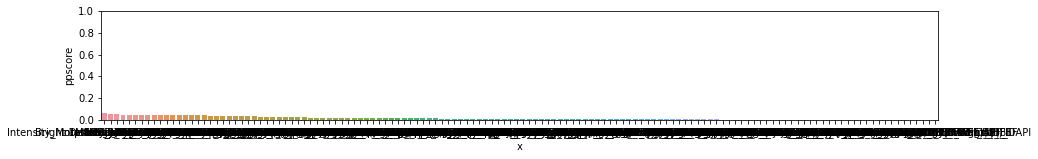

In [29]:
fig, ax = plt.subplots(figsize=(15,2))
seaborn.barplot(data=res_201, x="x", y="ppscore", ax=ax)
ax.set_ylim(0, 1)

In [31]:
res_201.loc[res_201["ppscore"].argmax()]

x                 Intensity_Morphology(M07  DAPI)_DAPI
y                                               target
ppscore                                      0.0661762
case                                    classification
is_valid_score                                    True
metric                                     weighted F1
baseline_score                                  0.0552
model_score                                   0.117723
model                         DecisionTreeClassifier()
Name: 0, dtype: object

In [ ]:
fig, ax = plt.subplots(figsize=(15,2))
seaborn.barplot(data=res_control, x="x", y="ppscore", ax=ax)
ax.set_ylim(0, 1)

In [ ]:
res_control.loc[res["ppscore"].argmax()]

# Non-parametric outlier detection

In [32]:
import umap

In [33]:
# export

def umap_per_set(df, meta_df):
    umaps = []
    for (t_idx, r_idx), grouped_df in df.groupby([meta_df["timepoint"], meta_df["replicate"]]):

        print(f"{t_idx} - {r_idx}")

        res_df = pandas.DataFrame(umap.UMAP().fit_transform(grouped_df), columns=["dim_1", "dim_2"])
        res_df["timepoint"] = t_idx
        res_df["replicate"] = r_idx

        umaps.append(res_df)

    return pandas.concat(umaps)

In [34]:
umaps_201 = umap_per_set(df_201, df_201_meta)

T0 - R1
T0 - R2
T0 - R3
T2 - R1
T2 - R2
T2 - R3
T3 - R1
T3 - R2
T3 - R3
T4 - R1
T4 - R2
T4 - R3
T5 - R1
T5 - R2
T5 - R3
T6 - R1
T6 - R2
T6 - R3
T7 - R1
T7 - R2
T7 - R3


In [59]:
umaps_control = umap_per_set(df_control, df_control_meta)

T0 - R2
T0 - R3
T4 - R2
T4 - R3
T5 - R2
T5 - R3
T6 - R2
T6 - R3
T7 - R2
T7 - R3


## IsolationForest

In [35]:
from sklearn.ensemble import IsolationForest

In [36]:
# export

def outliers_per_set(df, meta_df, umaps):

    iso_forest = IsolationForest()

    for (t_idx, r_idx), grouped_df in df.groupby([meta_df["timepoint"], meta_df["replicate"]]):
        preds = iso_forest.fit_predict(grouped_df)

        n_outliers = (preds==-1).sum()
        print(f"Isolation Forest identified {n_outliers} ({n_outliers/grouped_df.shape[1]:.2f}%) in {t_idx}, {r_idx}")

        umaps.loc[(umaps["timepoint"]==t_idx) & (umaps["replicate"]==r_idx), "outlier"] = preds

In [37]:
outliers_per_set(df_201, df_201_meta, umaps_201)

Isolation Forest identified 514 (3.84%) in T0, R1
Isolation Forest identified 205 (1.53%) in T0, R2
Isolation Forest identified 287 (2.14%) in T0, R3
Isolation Forest identified 539 (4.02%) in T2, R1
Isolation Forest identified 898 (6.70%) in T2, R2
Isolation Forest identified 458 (3.42%) in T2, R3
Isolation Forest identified 529 (3.95%) in T3, R1
Isolation Forest identified 731 (5.46%) in T3, R2
Isolation Forest identified 494 (3.69%) in T3, R3
Isolation Forest identified 646 (4.82%) in T4, R1
Isolation Forest identified 760 (5.67%) in T4, R2
Isolation Forest identified 579 (4.32%) in T4, R3
Isolation Forest identified 848 (6.33%) in T5, R1
Isolation Forest identified 114 (0.85%) in T5, R2
Isolation Forest identified 624 (4.66%) in T5, R3
Isolation Forest identified 173 (1.29%) in T6, R1
Isolation Forest identified 349 (2.60%) in T6, R2
Isolation Forest identified 138 (1.03%) in T6, R3
Isolation Forest identified 38 (0.28%) in T7, R1
Isolation Forest identified 305 (2.28%) in T7, R2
I

In [66]:
outliers_per_set(df_control, df_control_meta, umaps_control)

Isolation Forest identified 402 (3.00%) in T0, R2
Isolation Forest identified 27 (0.20%) in T0, R3
Isolation Forest identified 173 (1.29%) in T4, R2
Isolation Forest identified 114 (0.85%) in T4, R3
Isolation Forest identified 197 (1.47%) in T5, R2
Isolation Forest identified 270 (2.01%) in T5, R3
Isolation Forest identified 1213 (9.05%) in T6, R2
Isolation Forest identified 561 (4.19%) in T6, R3
Isolation Forest identified 756 (5.64%) in T7, R2
Isolation Forest identified 337 (2.51%) in T7, R3


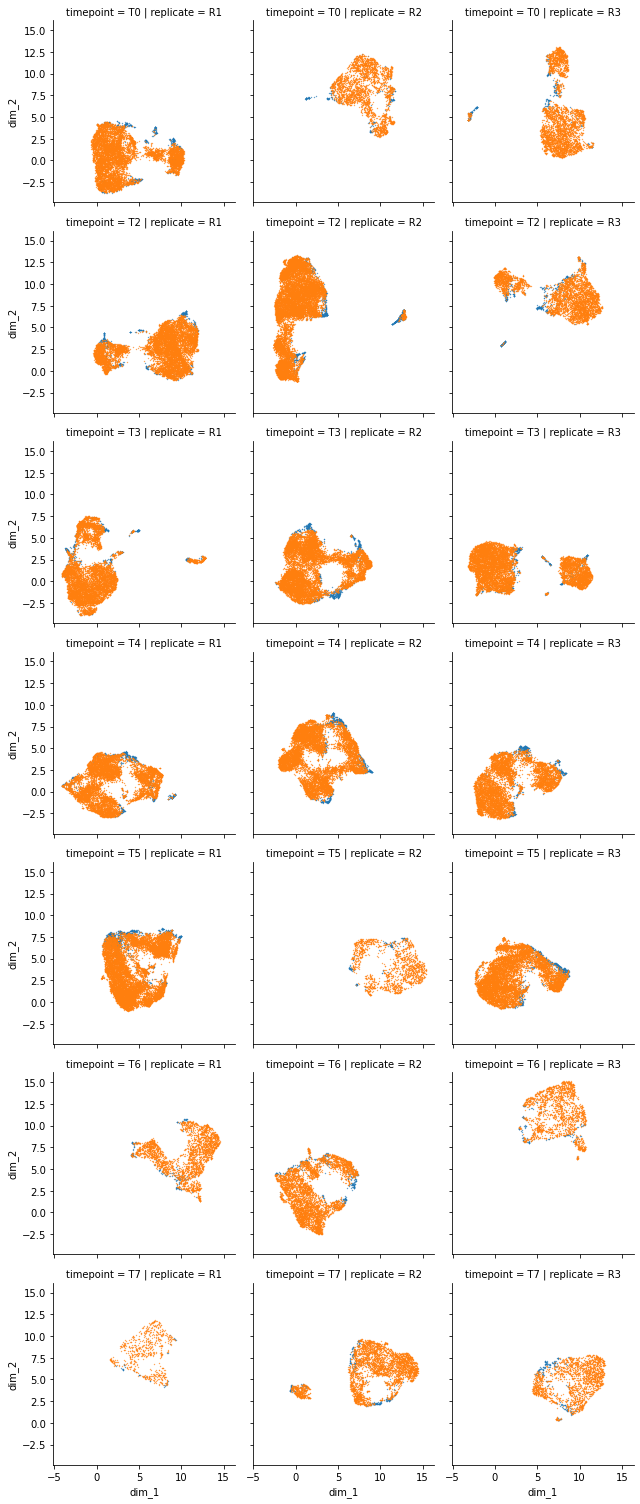

In [38]:
grid = seaborn.FacetGrid(col="replicate", row="timepoint", hue="outlier", data=umaps_201)
grid = grid.map(plt.scatter, "dim_1", "dim_2", s=0.1)

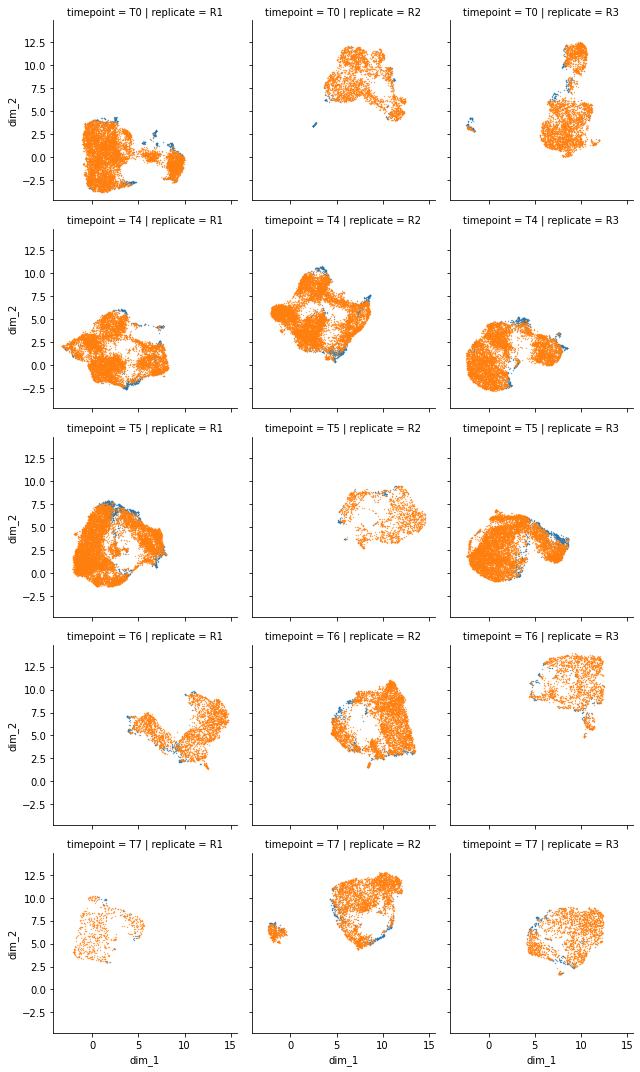

In [68]:
grid = seaborn.FacetGrid(col="replicate", row="timepoint", hue="outlier", data=umaps_201)
grid = grid.map(plt.scatter, "dim_1", "dim_2", s=0.1)

# export

In [13]:
from ehv import export

In [39]:
export.to_fcs(
    pandas.concat([df_201, df_201_meta], axis=1), 
    "D:/Experiment_data/weizmann/EhV/201/aggregates/non_intensity_T0234567_R123.fcs"
)